In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F
from fastcore.test import test_close
from urllib.request import urlretrieve
#torch.manual_seed(42)

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)
# path_data = Path('data')
# path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## setup


In [2]:
n,m = x_train.shape
c = y_train.max() +1
nh = 50
n,m,c

(50000, 784, tensor(10))

In [3]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]

    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [4]:
model = Model(m,nh,10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

## Cross Entropy loss

In [5]:
def log_softmax(x): return (x.exp() / (x.exp().sum(-1,keepdim=True))).log()

In [6]:
log_softmax(pred)

tensor([[-2.26, -2.24, -2.40,  ..., -2.31, -2.36, -2.53],
        [-2.21, -2.23, -2.40,  ..., -2.38, -2.41, -2.46],
        [-2.31, -2.30, -2.21,  ..., -2.35, -2.37, -2.48],
        ...,
        [-2.17, -2.30, -2.28,  ..., -2.30, -2.46, -2.43],
        [-2.21, -2.28, -2.29,  ..., -2.34, -2.34, -2.43],
        [-2.25, -2.25, -2.38,  ..., -2.29, -2.32, -2.51]], grad_fn=<LogBackward0>)

In [7]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [8]:
def logsumexp(x):
  m = x.max(-1)[0]
  return m + (x -m[:,None]).exp().sum(-1).log()

In [9]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [10]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.26, -2.24, -2.40,  ..., -2.31, -2.36, -2.53],
        [-2.21, -2.23, -2.40,  ..., -2.38, -2.41, -2.46],
        [-2.31, -2.30, -2.21,  ..., -2.35, -2.37, -2.48],
        ...,
        [-2.17, -2.30, -2.28,  ..., -2.30, -2.46, -2.43],
        [-2.21, -2.28, -2.29,  ..., -2.34, -2.34, -2.43],
        [-2.25, -2.25, -2.38,  ..., -2.29, -2.32, -2.51]], grad_fn=<SubBackward0>)

In [11]:
y_train[:3]

tensor([5, 0, 4])

In [12]:
sm_pred[0,5], sm_pred[1,0], sm_pred[2,4]

(tensor(-2.22, grad_fn=<SelectBackward0>),
 tensor(-2.21, grad_fn=<SelectBackward0>),
 tensor(-2.23, grad_fn=<SelectBackward0>))

In [13]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.22, -2.21, -2.23], grad_fn=<IndexBackward0>)

In [14]:
def nll(input, target):return -input[range(target.shape[0]),target].mean()

In [15]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [16]:
test_close(F.nll_loss(F.log_softmax(pred,-1), y_train),loss, 1e-3)

In [17]:
test_close(F.cross_entropy(pred,y_train),loss,1e-3)

## basic training Loop

In [18]:
loss_func = F.cross_entropy

In [19]:
bs=64        # batch size
# xb = x_train[0:bs]
# preds =model(xb)
# preds[0], preds.shape

In [20]:
# yb = y_train[0:64]
# yb

In [21]:
# xb.shape, yb.shape

In [22]:
# loss_func(preds, yb)

In [23]:
# preds.argmax(dim=1)

In [24]:
def accuracy(out,yb): return (out.argmax(dim=1)==yb).float().mean()

In [25]:
# accuracy(preds,yb)

In [26]:
lr=0.5
epochs=3

In [27]:
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [28]:
# xb.shape, yb.shape

In [29]:
# xb,yb = x_train[:bs],y_train[:bs]
# preds = model(xb)
# report(loss_func(preds, yb), preds, yb)

In [94]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb_,yb_ = x_train[s],y_train[s]
        import pdb; pdb.set_trace()
        preds = model(xb_)
        loss = loss_func(preds, yb_)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
    #report(loss, preds, yb)


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-94-20057347fd47>(6)<cell line: 1>()
      4         xb_,yb_ = x_train[s],y_train[s]
      5         import pdb; pdb.set_trace()
----> 6         preds = model(xb_)
      7         loss = loss_func(preds, yb_)
      8         loss.backward()

ipdb> xb.shape,yb.shape
(torch.Size([64, 784]), torch.Size([64]))
ipdb> q



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)



In [31]:
# for epoch in range(epochs):
#   for i in range(0,n,bs):
#     s = slice(i, min(n,i+bs))
#     xb,yb = x_train[s],y_train[s]
#     preds = model(xb)
#     loss = loss_func(preds,yb)
#     loss.backward()
#     if i==0:print(loss.item(), accuracy(preds,yb).item())
#     with torch.no_grad():
#       for l in model.layers:
#         if hasattr(l, 'weight'):
#           l.weight -= l.weight.grad*lr
#           l.bias   -= l.bias.grad   * lr
#           l.weight.grad.zero_()
#           l.bias.grad.zero_()

#   #report(loss,preds,yb)

## Parameters and Optim

#### Parameters

In [32]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [33]:
(list(m1.named_children()))

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [34]:
m1.named_children()

<generator object Module.named_children at 0x7d96670eb140>

In [35]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.09, -0.47,  0.47],
         [ 0.09, -0.20,  0.46],
         [ 0.08, -0.11,  0.00],
         [-0.34,  0.32, -0.52]], requires_grad=True),
 Parameter containing:
 tensor([-0.30,  0.15,  0.20, -0.39], requires_grad=True)]

In [36]:
class MLP(nn.Module):
  def __init__(self,n_in,nh,n_out):
    super().__init__()
    self.l1 = nn.Linear(n_in,nh)
    self.l2 = nn.Linear(nh,n_out)
    self.relu = nn.ReLU()

  def forward(self,x): return self.l2(self.relu(self.l1(x)))

In [37]:
model = MLP(m,nh,10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [38]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [39]:
for name,l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [40]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [41]:
def fit():
  for epoch in range(epochs):
    for i in range(0,n,bs):
      s = slice(i,min(n,i+bs))
      xb,yb = x_train[s],y_train[s]
      preds = model(xb)
      loss = loss_func(preds,yb)
      loss.backward()
      #if i==0:print(loss.item(), accuracy(preds,yb).item())
      if i==0:print(f'{loss.item():.2f}, {accuracy(preds,yb).item():.2f}')
      with torch.no_grad():
        for p in model.parameters(): p -= p.grad *lr
        model.zero_grad()

    #report(loss,preds,yb)

In [42]:
fit()

2.31, 0.17
0.15, 0.95
0.10, 0.95


Lets creat our own nn.Module

In [43]:
class MyModule():
  def __init__(self, n_in, nh, n_out):
    self._modules = {}
    self.l1 = nn.Linear(n_in, nh)
    self.l2 = nn.Linear(nh, n_out)

  def __setattr__(self,k, v):
    if not k.startswith("_"): self._modules[k] = v
    super().__setattr__(k,v)

  def __repr__(self): return f'{self._modules}'

  def parameters(self):
    for l in self._modules.values():
      #for p in l.parameters(): yield p  # the above can be more factored into
      yield from l.parameters()

In [44]:
md1 = MyModule(m,nh,10)
md1

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [45]:
for p in md1.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


## Registering Modules

In [46]:
from functools import reduce

In [47]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [48]:
class Module(nn.Module):
  def __init__(self,layers):
    super().__init__()
    self.layers = layers
    for i,l in enumerate(self.layers): self.add_module(f'layer_{i}',l)

  def forward(self,x): return reduce(lambda val,layer: layer(val), self.layers,x)

In [49]:
model = Module(layers)
model

Module(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [50]:
# model(xb).shape

In [51]:
# xb.shape,yb.shape

## nn.ModuleList

In [52]:
class SequentialModule(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)

  def forward(self,x):
    for l in self.layers: x= l(x)
    return x

In [53]:
model = SequentialModule(layers)
model

SequentialModule(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [54]:
fit()

2.32, 0.09
0.09, 0.98
0.10, 0.95


### nn.Squential

In [55]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [56]:
fit()
#loss_func(model(xb),yb), accuracy(model(xb),yb)

2.31, 0.12
0.13, 0.97
0.10, 0.95


## Optimizer

In [57]:
class Optimizer():
  def __init__(self,params,lr=0.5): self.params,self.lr = list(params), lr

  def step(self):
    with torch.no_grad():
      for p in self.params: p -= p.grad * self.lr

  def zero_grad(self):
    for p in self.params: p.grad.data.zero_()

In [58]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [59]:
opt = Optimizer(model.parameters())

In [60]:
for epoch in range(epochs):
  for i in range(0,n,bs):
    s = slice(i, min(n, i+bs))
    xb,yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
  report(loss, preds,yb)

0.32, 0.88
0.20, 0.88
0.15, 0.88


In [61]:
from torch import optim

In [62]:
def get_model():
  model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
  return model, optim.SGD(model.parameters(), lr=lr)

In [63]:
model,opt = get_model()
#loss_func(model(xb),yb)

In [64]:
for epoch in range(epochs):
  for i in range(0,n,bs):
    s = slice(i, min(n, i+bs))
    xb,yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
  report(loss, preds,yb)

0.24, 0.88
0.16, 0.94
0.07, 1.00


## Datasets

we were iterating the mini-batches with xb,yb = x_train[s],y_train[s], we can facterize the code to:
 xb,yb =x_train[s] by using the Dataset class

In [65]:
class Dataset():
  def __init__(self,x,y): self.x, self.y = x,y
  def __len__(self): return len(self.x)
  def __getitem__(self,i): return self.x[i], self.y[i]

In [66]:
train_ds,valid_ds = Dataset(x_train,y_train), Dataset(x_valid, y_valid)
assert len(train_ds) == len(x_train)
assert len(valid_ds) == len(x_valid)

In [67]:
xb,yb = train_ds[0:5]
assert xb.shape == (5, 28*28)
assert yb.shape == (5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [68]:
model,opt = get_model()

In [69]:
for epoch in range(epochs):
  for i in range(0,n,bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    preds = model(xb)
    loss = loss_func(preds,yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
  report(loss,preds,yb)

0.28, 0.94
0.10, 1.00
0.04, 1.00


In [70]:
len(train_ds)

50000

## DataLoader

In [71]:
xb.shape, yb.shape

(torch.Size([16, 784]), torch.Size([16]))

In [72]:
class DataLoader():
  def __init__(self,ds,bs): self.ds, self.bs = ds,bs
  def __iter__(self):
    for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [73]:
train_dl = DataLoader(train_ds,bs)
valid_dl = DataLoader(valid_ds,bs)

In [74]:
xb,yb = next(iter(valid_dl))
xb.shape,yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [75]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7,
        6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1])

tensor(6)

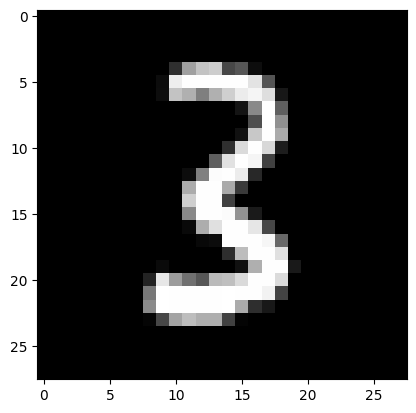

In [76]:
plt.imshow(xb[0].view(28,28))
yb[2]

In [77]:
model,opt = get_model()

In [95]:
def fit():
  for epoch in range(epochs):
    for xb,yb in train_dl:
      import pdb; pdb.set_trace()
      preds = model(xb)
      loss = loss_func(preds,yb)
      loss.backward()
      opt.step()
      opt.zero_grad()
    report(loss,preds,yb)

In [96]:
fit()
loss_func(model(xb),yb),accuracy(model(xb),yb)

> <ipython-input-95-871220245baf>(5)fit()
      3     for xb,yb in train_dl:
      4       import pdb; pdb.set_trace()
----> 5       preds = model(xb)
      6       loss = loss_func(preds,yb)
      7       loss.backward()

ipdb> xb.shape,yb.shape
(torch.Size([64, 784]), torch.Size([64]))
ipdb> q


## Random Sampling

In [80]:
import random
from itertools import islice

In [81]:
class Sampler():
  def __init__(self, ds, shuffle=False): self.n, self.shuffle = len(ds), shuffle
  def __iter__(self):
    res = list(range(self.n))
    if self.shuffle: random.shuffle(res)
    return iter(res)

In [82]:
ss = Sampler(train_ds)

In [83]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [84]:
list(islice(ss,5))

[0, 1, 2, 3, 4]

In [85]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss,5))

[3155, 1365, 43043, 12764, 1603]

In [86]:
import fastcore.all as fc

In [87]:
class BatchSampler():
  def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    #self.sampler,self.bs, self.drop_last =sampler,bs,drop_last
  def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last = self.drop_last)

In [88]:
Batchs = BatchSampler(ss,4)
list(islice(Batchs,5))

[[26096, 17375, 9012, 29544],
 [7842, 45863, 10274, 42607],
 [35960, 22545, 36811, 12429],
 [48082, 27438, 38088, 39956],
 [29385, 40572, 9383, 46884]]

In [89]:
def collate(b):
  xs,ys = zip(*b)
  return torch.stack(xs),torch.stack(ys)

In [90]:
class DataLoader():
  def __init__(self,ds, batchs, collate_fn=collate): fc.store_attr()
  def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [91]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True),bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False),bs)

In [92]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

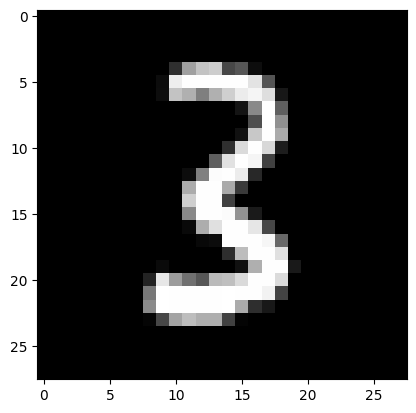

In [93]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]